In [325]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [326]:
from PIL import Image
from pigs import Pigs
import matplotlib.pyplot as plt
import numpy as np

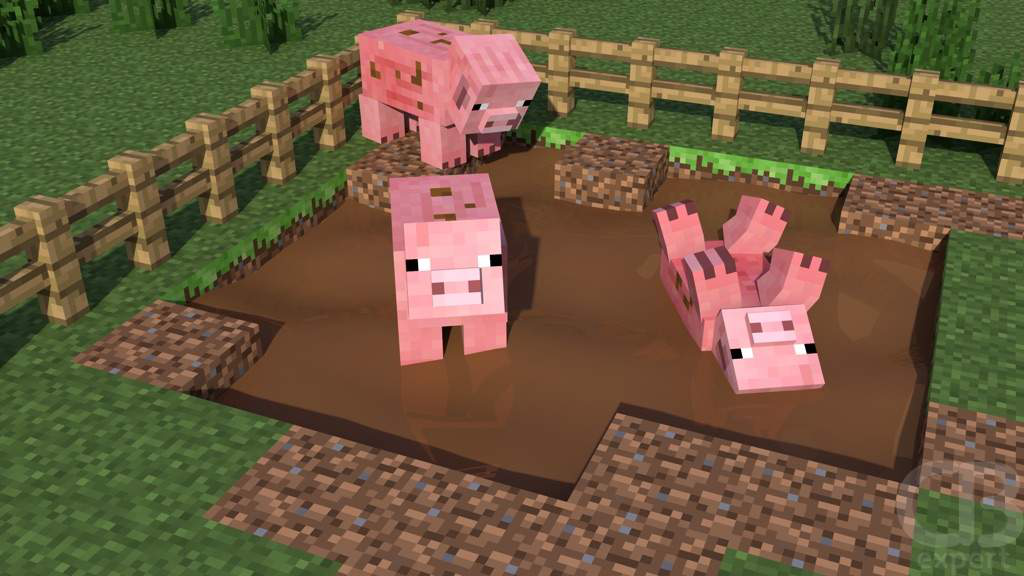

In [327]:
# image = Image.open('flower.jpg')
image = Image.open('pigs.jpg')

image

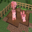

In [254]:
# im_size = (2**6, 2**6)
m = 5
im_size = (2**m, 2**m)
image_ = image.resize(im_size, )
image_

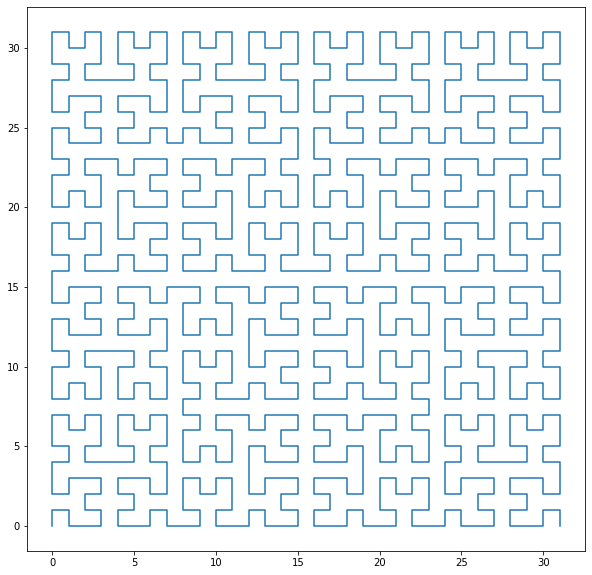

In [255]:
import numpy as np
from hilbert import decode, encode
# m = 3
locs = decode(np.arange(2**m*2**m), 2, m).astype(np.int)

plt.figure(figsize=(10,10))
plt.plot(locs[:,0], locs[:,1])

In [256]:
from scipy.ndimage import sobel



In [257]:
'''Hilbert flattenning'''
ndarray_image = np.array(image_).astype(int) #/ 255
ndarray_sobel = sobel(ndarray_image, axis=1)

flatted_image = ndarray_image[locs[:,0], locs[:,1]]
flatted_sobel = ndarray_sobel[locs[:,0], locs[:,1]]

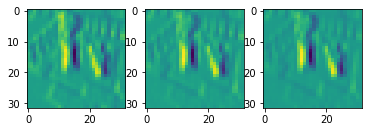

In [258]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(ndarray_sobel[:,:,0])
ax[1].imshow(ndarray_sobel[:,:,1])
ax[2].imshow(ndarray_sobel[:,:,2])

In [259]:
# general flattening
# flatted_image = np.array(image_).astype(float) / 255
# flatted_image = flatted_image.reshape((im_size[0]*im_size[1],3))
flatted_image.shape

(1024, 3)

In [260]:
def _rgb_pos_kernel(rgb1,rgb2,pos1,pos2,N,beta):
    l2 = np.sqrt(((rgb1[0] - rgb2[0]))**2 + 
                 ((rgb1[1] - rgb2[1]))**2 + 
                 ((rgb1[2] - rgb2[2]))**2 +
                 ((pos1[0] - pos2[0])/(N))**2 + 
                 ((pos1[1] - pos2[1])/(N))**2)
    return np.exp(-beta * l2)

def _rgb_pos_kernel(rgb1,rgb2,pos1,pos2,N,beta):
    pos = (pos1[0] - pos2[0])/(N) 
    l2 = np.sqrt(((rgb1[0] - rgb2[0]) + pos)**2 + 
                 ((rgb1[1] - rgb2[1]) + pos)**2 + 
                 ((rgb1[2] - rgb2[2]) + pos)**2)
    return np.exp(-beta * l2)

def rgb_pos_kernel(rgb1,rgb2,pos1,pos2,N,beta):
    pos = abs((pos1[0] - pos2[0]) + (pos1[1] - pos2[1])) / (2*N) 
    l2 = np.sqrt((rgb1[0] - rgb2[0] + pos)**2 + 
                 (rgb1[1] - rgb2[1] + pos)**2 + 
                 (rgb1[2] - rgb2[2] + pos)**2)
    result = np.exp(-beta * l2)
#     print('{} | {} | {:.3f} | {:.3f} | {:.3f}'.format(pos1,pos2,pos,l2,result))
    return result

print('\n',
    rgb_pos_kernel([1,1,1], [1,1,1], (1,1),(1,1),2, 1),
    rgb_pos_kernel([1,1,1], [1,1,1], (1,0),(1,0),2, 1),
    rgb_pos_kernel([1,1,1], [1,1,1], (1,0),(0,1),2, 1),
    rgb_pos_kernel([0,1,1], [1,1,1], (1,0),(0,1),2, 1),
    rgb_pos_kernel([1,1,1], [0,0,0], (0,0),(2,2),2, 1)
)


 1.0 1.0 1.0 0.36787944117144233 0.03130111324493289


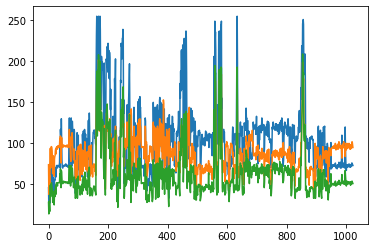

In [261]:
plt.plot(flatted_image)

In [262]:
vec = np.zeros((flatted_image.shape[0], 6))
vec[:,:3] = flatted_image
vec[:,3] = np.exp(-1/flatted_sobel[:,0]) 
vec[:,4] = locs[:,0]#//N
vec[:,5] = locs[:,1]#//N

/home/ivan/tools/anaconda3/envs/bbn/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [263]:
%%time
G = (vec @ vec.T)

CPU times: user 17.5 ms, sys: 30 ms, total: 47.5 ms
Wall time: 6.95 ms


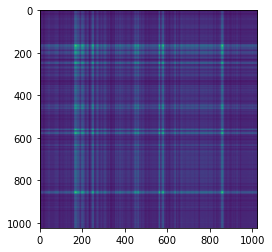

In [264]:
plt.imshow(G)

In [265]:
# %%time
# N = flatted_image.shape[0]
# beta = 1/20#13.2#50

# G = np.zeros((N,N))
# for i in range(N):
#     for j in range(N):
#         if i > j: #and abs(i-j) < N//3:
#             i1 = flatted_image[i]
#             j2 = flatted_image[j]
#             i_point = (locs[i,0],locs[i,1])
#             j_point = (locs[j,0],locs[j,1])
#     #         print(i_point, j_point)
#             G[i,j] = rgb_pos_kernel(i1, j2, 
#                                     i_point ,j_point, # hilbert flattening
#     #                                     (i//N,i%N), (j//N,j%N), # general flattening
#                                     N, beta*2)
# G += G.T
# for i in range(N): G[i,i]=1

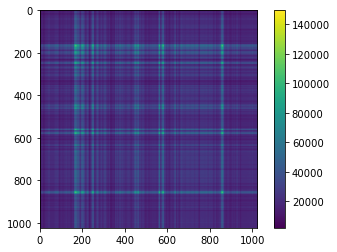

In [266]:
plt.imshow(G)
plt.colorbar()

In [267]:
pig = Pigs(stop=1e-3, verbose=True, beta=1)

In [268]:
%%time
degree, laplace = pig.compute_LD(G)


CPU times: user 23.4 ms, sys: 5.13 ms, total: 28.6 ms
Wall time: 20.2 ms


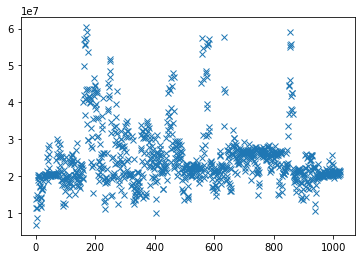

In [269]:
plt.figure()
plt.plot(degree, 'x')
# plt.figure()
# plt.imshow(laplace)
# plt.colorbar()

Root node: 168
CPU times: user 175 ms, sys: 132 ms, total: 308 ms
Wall time: 53.6 ms


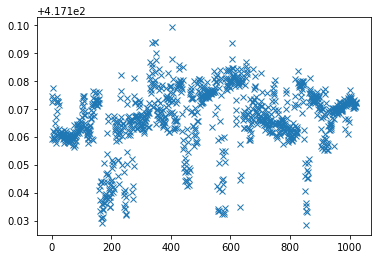

In [270]:
%%time
x, root_node = pig.linear_solver(degree, laplace)
plt.figure()
plt.plot(x, 'x')

In [271]:
%%time
threshold, ir = pig.compute_IR_threshold(x, G, degree)
print(threshold, ir )
mask = pig.generate_mask(flatted_image, x, threshold, root_node)

417.13198770843053 0.010368869160130984
CPU times: user 525 ms, sys: 13.9 ms, total: 539 ms
Wall time: 524 ms


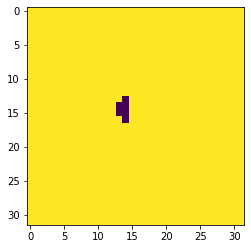

In [272]:
msk = np.zeros(im_size)
for i, pos in enumerate(locs):
    msk[pos[0],pos[1]] = mask[i]
    
# plt.imshow(mask.reshape(im_size))
plt.imshow(msk)

In [273]:
# msk = mask.reshape(im_size)
np_img = np.array(image_)
msk_img = np.zeros_like(np_img)
for i in range(3):
    msk_img[:,:,i] = np.ma.masked_where(msk, np_img[:,:,i])

In [274]:
# msk = np.logical_not(msk)
# np_img[msk,0] = 0
# np_img[msk,1] = 0
# np_img[msk,2] = 0


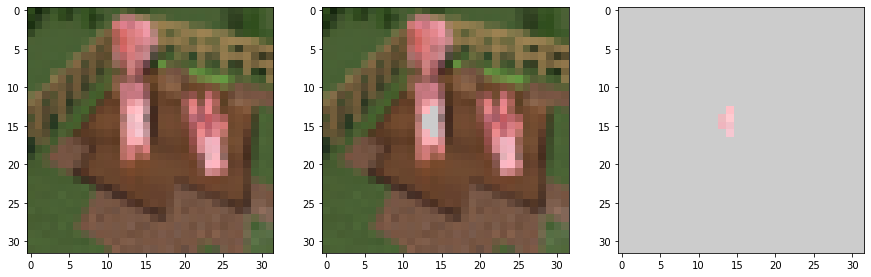

In [275]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(image_)

ax[1].imshow(np_img)
ax[1].imshow(np.ma.masked_where(msk, msk), 'nipy_spectral_r')

msk_ = np.logical_not(msk)
ax[2].imshow(np_img)
ax[2].imshow(np.ma.masked_where(msk_, msk_), 'nipy_spectral_r')



In [276]:
'''NEXT ITERATION'''

'NEXT ITERATION'

In [287]:
mask = np.logical_not(mask)

In [288]:
ids = np.where(mask)[0]

In [313]:
new_vec = vec[mask]
# new_vec[:,:3] = new_vec[:,:3]
# new_vec = new_vec
new_G = (new_vec @ new_vec.T)
# new_G = new_G - new_G.max()

In [314]:
new_G = (new_vec @ new_vec.T)

In [315]:
# %%time
# new_N = len(ids)
# new_G = np.zeros((new_N, new_N))
# N = flatted_image.shape[0]

# for ki, i in enumerate(ids):
#     for kj, j in enumerate(ids):
#         if ki > kj: #and abs(i-j) < N//3:
#             i1 = flatted_image[i]
#             j2 = flatted_image[j]
#             i_point = (locs[i,0],locs[i,1])
#             j_point = (locs[j,0],locs[j,1])
#             new_G[ki,kj] = rgb_pos_kernel(i1, j2, 
#                                     i_point ,j_point, # hilbert flattening
#                                     N, beta*2)
# new_G += new_G.T

In [316]:
new_degree, new_laplace = pig.compute_LD(new_G)
# new_degree = degree[mask]
# new_laplace = laplace[mask][:,mask]
# new_G = G[mask][:,mask]

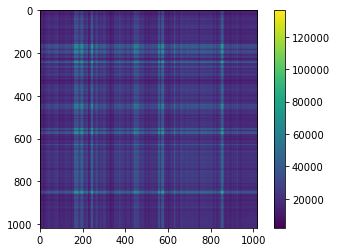

In [317]:
plt.imshow(new_G)
plt.colorbar()

In [318]:
%%time
new_x, new_root_node = pig.linear_solver(new_degree, new_laplace)

Root node: 629
CPU times: user 81 ms, sys: 23 ms, total: 104 ms
Wall time: 18.7 ms


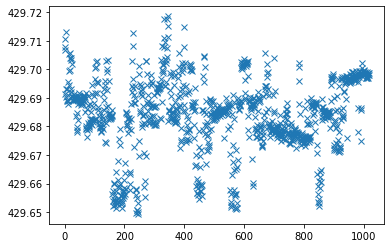

In [319]:
plt.plot(new_x, 'x')

In [320]:
new_x.shape, new_G.shape, new_degree.shape

((1017,), (1018, 1018), (1018,))

In [321]:
%%time
new_threshold, new_ir = pig.compute_IR_threshold(new_x, new_G, new_degree)
print(new_threshold, new_ir)

429.65281070198466 0.034534980878973456
CPU times: user 574 ms, sys: 12.6 ms, total: 587 ms
Wall time: 573 ms


In [322]:
new_mask = pig.generate_mask(flatted_image[mask], new_x, new_threshold, new_root_node)

(1024,) (1018,) 1024


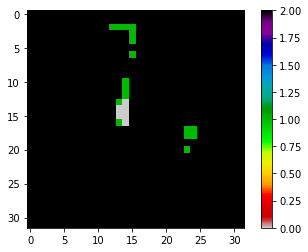

In [323]:
print(mask.shape, new_mask.shape, im_size[0]*im_size[1])
total_mask = np.zeros(im_size[0]*im_size[0], dtype='uint8')
total_mask[mask] = 1
tmp = total_mask[mask]
tmp[new_mask] = 2
total_mask[mask] = tmp

total_mask_img = np.zeros(im_size)
for i, pos in enumerate(locs):
    total_mask_img[pos[0],pos[1]] = total_mask[i]
    
# total_mask_img = total_mask.reshape(im_size)

plt.imshow(total_mask_img, 'nipy_spectral_r')
plt.colorbar()
plt.show()

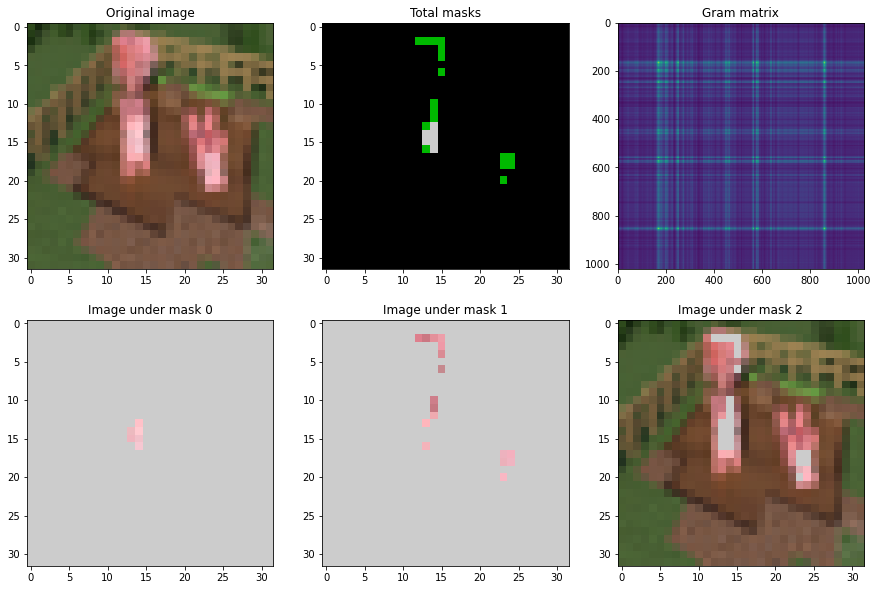

In [324]:
p_mult = 1
fig, ax = plt.subplots(2,3, figsize=(15*p_mult,10*p_mult))#, dpi=1100)

ax[0,0].set_title('Original image')
ax[0,0].imshow(image_)

ax[0,1].set_title('Total masks')
ax[0,1].imshow(total_mask_img, 'nipy_spectral_r')

ax[0,2].set_title('Gram matrix')
ax[0,2].imshow(G)

name = [0,1,2]
for i in [1,2,0]:
    msk = total_mask_img == i
    
    _name = name[i]
    ax[1,i].set_title(f'Image under mask {_name}')
    ax[1,i].imshow(np_img)
    ax[1,i].imshow(np.ma.masked_where(msk, msk), 'nipy_spectral_r')
